# 导入必要库

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import time
import numpy as np
import tushare as ts
import seaborn as sns
import seaborn.regression as snsl
import warnings
warnings.filterwarnings('ignore') # 不显示warning

# 设置tushare的token，变成高级用户
- 进入tushare官网注册登录后，进入个人中心，在如下图所示地方找到token
![设置token](./image/token.png)


In [2]:
ts.set_token('XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX')
pro = ts.pro_api()

# 主要函数
* `SigFundPlot(code, ann_time, enn_time)`:画出一直基金的走势图，输入为基金code，开始时间和结束时间；函数无输出值
* `sharpe_ratio(return_list)`:计算夏普比率，输入为基金pct_change序列；输出为夏普比率
* `ComFundRoRD2D(fund_list, bili_list, ann_date, enn_date= True)`:组合基金按时间计算收益率，并计算同期沪深300收益率。输入为基金列表，每只基金所对应的比例，开始时间，结束时间，结束时间可以不输入，默认为即日；函数输出值为组合收益率，同期沪深300收益率，夏普比率，组合净值，互相关性矩阵
* `MaxDrawdownPlot(a,b)`:画出收益率曲线和最大回撤，输入为函数`ComFundRoRD2D`返回值的前两项，即组合收益率和同期沪深300收益率。
    
*后文有具体介绍*

## SigFundPlot
<font color= "red"><center>输入参数：</center></font>

名称 | 类型 | 必选 | 描述 
:-: | :-: | :-: | :-: 
code | str | Y| 基金代码
ann_time | str| Y| 开始时间
enn_time | str | Y| 结束时间

In [3]:
def SigFundPlot(code, ann_time, enn_time):
    df_temp = pro.fund_nav(ts_code=code)
    df_temp = df_temp.set_index('end_date')
    df_temp = df_temp.sort_index(ascending=True)
    df_temp.index.name = 'date'
    df_temp.index = pd.DatetimeIndex(df_temp.index)
    #enn_time = enn_time.strftime("%Y%m%d")
    #ann_time = ann_time.strftime("%Y%m%d")
    one_year = df_temp.loc[ann_time:enn_time]
    one_year = one_year.drop_duplicates()   # 删除重复行
    plt.figure(figsize=(15,5))
    plt.plot(one_year['adj_nav'].pct_change().cumsum().fillna(0)*100)
    plt.xlabel('time')
    plt.ylabel('ROR/%')
    plt.show()

## sharpe_ratio
<font color= "red"><center>输入参数：</center></font>

名称 | 类型 | 必选 | 描述 
:-: | :-: | :-: | :-: 
return_list | DataFrame | Y| 净值相对前一天的百分比*100


In [4]:
def sharpe_ratio(return_list):
    average_return = np.mean(return_list)
    return_stdev = np.std(return_list)
    sharpe_ratio = (average_return-0.04) * np.sqrt(252)  / return_stdev  #默认252个工作日,无风险利率为0.02
    return sharpe_ratio

## ComFundRoRD2D
<font color= "red"><center>输入参数：</center></font>

名称 | 类型 | 必选 | 描述 
:-: | :-: | :-: | :-: 
fund_list | list | Y| 基金代码列表
bili_list | list| Y| 基金对应比例列表
ann_date | str | Y| 开始时间
enn_date |str | N |结束时间，默认为今天


<font color= "red"><center>输出参数：</center></font>
 
名称 | 类型 | 默认显示 | 描述 
- | - | - | - 
hechengshouyl | Series | Y| 组合收益率
hz300_change | Series| Y| 同期沪深300收益率
shapre_ra | float64 | Y| 夏普比率
com_unit_nav | Series| Y | 组合净值
xiangguanxing | DataFrame | Y| 基金互相关性矩阵

In [5]:
def ComFundRoRD2D(fund_list, bili_list, ann_date, enn_date= True):
    df_1 = pd.DataFrame()
    jingzhi = pd.DataFrame()
    for fund in fund_list:
        df_temp = pro.fund_nav(ts_code=fund)
        df_temp = df_temp.set_index('end_date')
        df_temp = df_temp.sort_index(ascending=True)
        df_temp.index.name = 'date'
        df_1 = df_1.join(pd.DataFrame({fund:df_temp['adj_nav']}),how='outer')#adj_nav
        jingzhi = jingzhi.join(pd.DataFrame({fund:df_temp['adj_nav']}),how='outer')
        tech_rets = df_1.pct_change()
        xiangguanxing = tech_rets.corr()
    if enn_date == True:
        end = datetime.date.today()
        end = end.strftime("%Y%m%d")
    else:
        end = enn_date    
    start = ann_date
    #start = datetime.date(end.year-huiceyear,end.month,end.day)
   # start = start.strftime("%Y%m%d") 
    one_year = df_1.loc[start:end]
    jingzhi_year = jingzhi.loc[start:end]
    one_year = one_year.drop_duplicates()   # 删除重复行
    jingzhi_year = jingzhi_year.drop_duplicates()
    #计算组合基金净值
    com_unit_nav = 0
    for i in range(len(fund_list)):
        com_unit_nav = com_unit_nav + jingzhi_year[fund_list[i]] * bili_list[i]
    
    com_unit_nav.index = pd.to_datetime(com_unit_nav.index)
    
    one_year_sharp = one_year.pct_change().fillna(0)*100  #sharp_ratio xulie
    sharp_list = 0
    for i in range(len(fund_list)):
        sharp_list = sharp_list + one_year_sharp[fund_list[i]] * bili_list[i]
    shouyilv = one_year.pct_change().cumsum().fillna(0)
    shouyilv.index = pd.DatetimeIndex(shouyilv.index)
    hechengshouyl = 0
    for i in range(len(fund_list)):
        hechengshouyl = hechengshouyl + shouyilv[fund_list[i]] * bili_list[i]
    ## 同期沪深指数
    hz300 = pro.index_daily(ts_code='399300.SZ', start_date=start, end_date=end)
    hz300 = hz300.set_index('trade_date')
    hz300.index.name = 'date'
    hz300 = hz300.sort_index(ascending=True)
    hz300_close = hz300['close']
    hz300_change = hz300_close.pct_change().cumsum().fillna(0)
    hz300_change.index = pd.DatetimeIndex(hz300_change.index)
    
    # 计算夏普比率
    shapre_ra= sharpe_ratio(sharp_list)
    
    return hechengshouyl,hz300_change,shapre_ra,com_unit_nav,xiangguanxing

## MaxDrawdownPlot
<font color= "red"><center>输入参数：</center></font>

名称 | 类型 | 必选 | 描述 
:-: | :-: | :-: | :-: 
a |  Series| Y| 组合基金收益率
b | Series| Y| 同期沪深300收益率


In [6]:
def MaxDrawdownPlot(a,b):
    a.index = pd.DatetimeIndex(a.index)
    return_list = a 
    '''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  # 结束位置
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])
    '''
    i = np.argmax(np.maximum.accumulate(return_list) - return_list)  # 结束位置

    j = np.argmax(return_list[:i])  # 开始位置
    
    huiche2 = return_list[j] - return_list[i]
    print(huiche2)
    #fig,ax = plt.figure(figsize=(15,5))
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(a)
    if min(b)<min(a):
        ax.vlines(i,min(b),a[i],alpha = 0.25)
        ax.vlines(j,min(b),a[j],alpha = 0.25)
        ax.fill_between(a.index,min(b),a ,where = (a.index>=j)& (a.index<=i),alpha = 0.25,facecolor='green')
    else:
        ax.vlines(i,min(a),a[i],alpha = 0.25)
        ax.vlines(j,min(a),a[j],alpha = 0.25)
        ax.fill_between(a.index,min(a),a ,where = (a.index>=j)& (a.index<=i),alpha = 0.25,facecolor='green')
    ax.plot(b)
    ax.plot([i, j], [a[i], a[j]], 'o', color="r", markersize=10)
    ax.spines['top'].set_visible(False) 
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # 设置 x 轴颜色
    ax.spines['bottom'].set_color('lightgray')
    plt.xticks(color = 'gray',rotation = 15)
    ax.grid(axis = 'y', color = 'lightgray', linestyle = '-', linewidth = 0.5)
    plt.show()


## CrossCorrelation
<font color= "red"><center>输入参数：</center></font>

名称 | 类型 | 必选 | 描述 
:-: | :-: | :-: | :-: 
relate |  DataFrame| Y| 基金互相关性矩阵

In [7]:
def CrossCorrelation(relate):
    colormap = plt.cm.viridis#Oranges
    sns.heatmap(relate,linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
    plt.show()

## DingTouProfile
<font color= "red"><center>输入参数：</center></font>

名称 | 类型 | 必选 | 描述 
:-: | :-: | :-: | :-: 
dt_fund | Series | Y| (组合)基金净值
dt_per_money | number | Y| 每次投入金额
freq | int | Y| 定投频率 1:每周 2:每两周 3:每月 


<font color= "red"><center>输出参数：</center></font>
 
名称 | 类型 | 默认显示 | 描述 
- | - | - | - 
chiyoushouyi | Series | Y| 持有收益
cysy_r| Series| Y| 持有收益率
total_money | float64 | Y| 定投总金额

In [8]:
def DingTouProfile(dt_fund, dt_per_money, freq):
    
    dt_per_money_jl = [] #投入记录
    #10,20  #投资频率
    if freq ==1:
        dt_fre = 5
    elif freq==2:
        dt_fre = 10
    else:
        dt_fre = 20
    
    accum_money = [] #累计投入
    accum_fene = []  #累计份额
    now_money = []  #现有资产
    chiyoushouyi = [] # 持有收益
    cysy_r = [] #持有收益率
    dt_per_money_irr = []
    for i in range(len(dt_fund)):
        if i%dt_fre == 0:
            dt_per_money_jl.append(dt_per_money)
            dt_per_money_irr.append(dt_per_money)
            accum_money.append(sum(dt_per_money_jl))
            temp_fene = dt_per_money/dt_fund.iloc[i]
            if i>1:
                accum_fene.append(temp_fene+accum_fene[i-1])
            else:
                accum_fene.append(temp_fene)
            dangqianzichan = accum_fene[i]*dt_fund.iloc[i]
            now_money.append(dangqianzichan)
            temp_cysy = dangqianzichan - accum_money[i]
            chiyoushouyi.append(temp_cysy)
            cysy_r.append(chiyoushouyi[i]/accum_money[i])
        else:
            dt_per_money_jl.append(0)
            accum_money.append(accum_money[i-1])
            accum_fene.append(accum_fene[i-1])
            dangqianzichan = accum_fene[i]*dt_fund.iloc[i]
            now_money.append(dangqianzichan)
            temp_cysy = dangqianzichan - accum_money[i]
            chiyoushouyi.append(temp_cysy)
            cysy_r.append(chiyoushouyi[i]/accum_money[i])
    total_money = accum_money[-1]
    return chiyoushouyi,cysy_r, total_money

## Yici_Profile
<font color= "red"><center>输入参数：</center></font>

名称 | 类型 | 必选 | 描述 
:-: | :-: | :-: | :-: 
dt_fund | Series | Y| (组合)基金净值
total_money | number | Y| 定投总金额


<font color= "red"><center>输出参数：</center></font>
 
名称 | 类型 | 默认显示 | 描述 
- | - | - | - 
yicimairucysy | Series | Y| 一次投入相同金额持有收益
yicimairucysy_r| Series| Y| 一次投入相同金额持有收益率

In [9]:
def Yici_Profile(dt_fund,total_money):
    yicimairuzichanzong = []
    yicimairucysy = []
    yicimairucysy_r = []
    yicimairufene = total_money/dt_fund.iloc[0]#accum_money[-1]
    for i in range(len(dt_fund)):
        dangqianzichan = yicimairufene*dt_fund.iloc[i]
        yicimairuzichanzong.append(dangqianzichan)
        temp_cysy = dangqianzichan - total_money#accum_money[-1]
        yicimairucysy.append(temp_cysy)
        yicimairucysy_r.append(yicimairucysy[i]/total_money)#accum_money[-1]
    return yicimairucysy,yicimairucysy_r

# 完整实例

In [16]:
fund_list = ['519732.OF','519727.OF','519697.OF']
bili_list = [0.3,0.35,0.35,]
a,b,c,d,relat = ComFundRoRD2D(fund_list,bili_list,'20190101')

0.15495687248368015


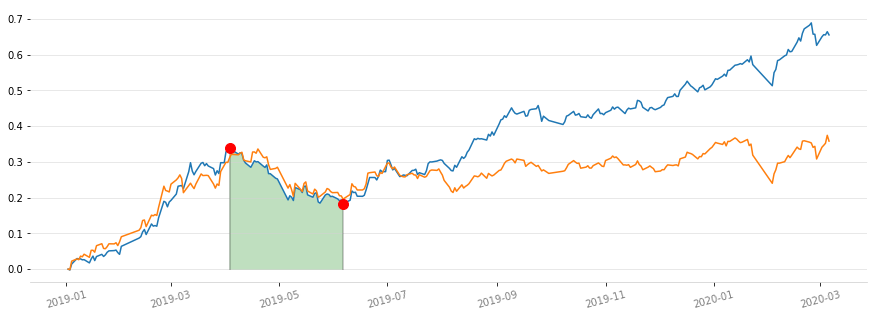

In [17]:
MaxDrawdownPlot(a,b)

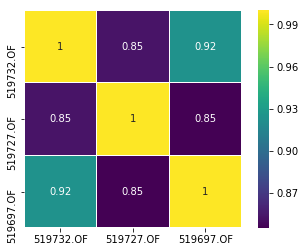

In [18]:
CrossCorrelation(relat)

In [19]:
dt_fund = d/d[0]
cy, cy_r,leiji_money = DingTouProfile(dt_fund,200,3)

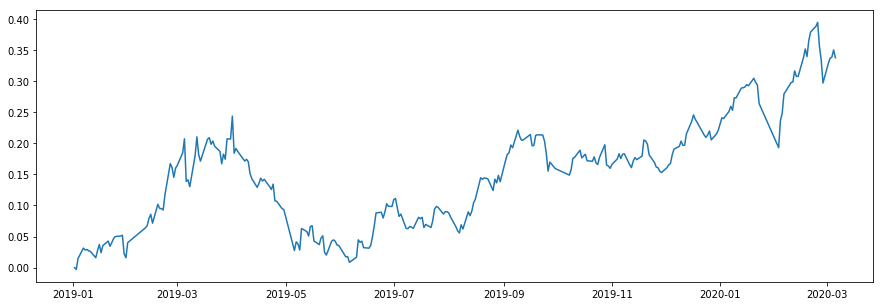

In [20]:
plt.figure(figsize=[15,5])
plt.plot(dt_fund.index,cy_r)
plt.show()

In [21]:
yici, yici_r = Yici_Profile(dt_fund,leiji_money)

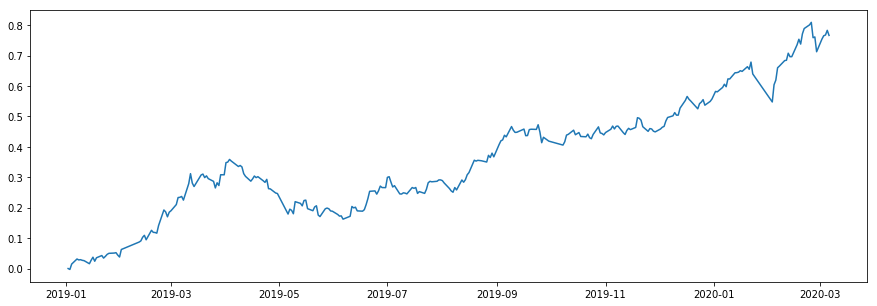

In [22]:
plt.figure(figsize=[15,5])
plt.plot(dt_fund.index,yici_r)
plt.show()